In [28]:
%matplotlib ipympl
from glob import glob
import pickle
import pandas as pd
import numpy as np

In [208]:
bout_file_names = sorted(glob("./data/bouts_*.pkl"))
bout_data = {}
for name in bout_file_names:
    date = name.split('_')[1][:-4]
    with open(name, 'rb') as f:
        bout_data[date] = pickle.load(f)

In [209]:
all_bouts = list(filter(lambda item: len(item[1].keys()) > 0, bout_data.items()))

In [31]:
banzuke_file_names = sorted(glob("./data/banzuke_*.pkl"))
banzuke_data = {}
for name in banzuke_file_names:
    date = name.split('_')[1][:-4]
    with open(name, 'rb') as f:
        banzuke_data[date] = pickle.load(f)

In [32]:
all_banzuke = list(filter(lambda item: len(item[1]) > 0, banzuke_data.items()))

In [8]:
from collections import defaultdict
import elo
import importlib
importlib.reload(elo)

def result_to_numeric(result):
     return 1 if result  == 'shiro' else 0

def mean_regression(ratings, basho):
    for name in basho[1].keys():
        ratings[name] = elo.mean_regression(ratings[name])
    return ratings

def play_tournament(ratings, basho):
    new_ratings = ratings.copy()
    for rikishi, bouts in basho[1].items():
        for bout in bouts:
            current_rating = ratings[rikishi]
            opponent_rating = ratings[bout['opponent']]
            result = 1 if bout['result'] == 'shiro' else 0
            new_ratings[rikishi] += elo.update_rating_sigmoid(current_rating, opponent_rating, result)
    return new_ratings

def play_all_bashos(ratings, basho_bouts):    
    for basho in basho_bouts:
        ratings = mean_regression(ratings, basho)
        ratings = play_tournament(ratings, basho)
    return ratings

ratings = defaultdict(lambda: 1000)
ratings = play_all_bashos(ratings, all_bouts[:-1])
pd.Series(ratings).sort_values(ascending=False)

Asashoryu       1179.575055
Akebono         1160.275069
Hakuho          1159.147665
Ama             1156.070252
Wakahanada      1155.130164
Harumafuji      1120.360396
Takahanada      1106.768213
Goeido          1097.845890
Onosho          1081.401878
Kotoshogiku     1078.110944
Kotomitsuki     1062.073735
Tochiazuma      1059.252470
Takayasu        1054.035354
Takanohana      1052.139797
Mitakeumi       1048.825654
Yoshikaze       1046.365878
Chiyonofuji     1044.091862
Onokuni         1043.317477
Takakeisho      1041.930936
Chiyotairyu     1041.421869
Tokusegawa      1036.124312
Aoiyama         1031.416628
Baruto          1031.029390
Tamawashi       1030.797177
Shohozan        1030.492068
Kisenosato      1029.619521
Ryukozan        1024.000000
Kakuryu         1022.760756
Asanoyama       1020.963335
Endo            1016.877262
                   ...     
Tamakairiki      871.645916
Fujiazuma        870.883852
Shikishima       870.703480
Terao            870.483055
Kirishima        869

In [14]:
banzuke = all_banzuke[-1]
names = [item['name'] for item in banzuke[1]]

def generate_opponents(names):
    bouts = {}
    NUM_DAYS = 15
    for name in names:
        opponents = list(filter(lambda n: n != name, names))
        bouts[name] = np.random.choice(opponents, replace=False, size=NUM_DAYS)
    return bouts

def simulate_single_tournament(bouts, ratings):
    new_ratings = ratings.copy()
    score_dist = defaultdict(int)
    for name, opponents in bouts.items():
        for opponent in opponents:
            current_rank = ratings[name]
            opponent_rank = ratings[opponent]
            p = elo.expected_outcome(current_rank, opponent_rank)
            outcome = 1 if np.random.random() < p else 0
            new_ratings[name] = elo.update_rating_sigmoid(current_rank, opponent_rank, outcome)
            score_dist[name] += outcome
    
    return new_ratings, score_dist

def simulate_tournament(names, ratings):
    NUM_SAMPLES = 10000
    score_dists = []
    for i in range(NUM_SAMPLES):
        bouts = generate_opponents(names)
        _, score_dist = simulate_single_tournament(bouts, ratings)
        score_dists.append(pd.Series(score_dist))

    return sum(score_dists) / NUM_SAMPLES

outcome = simulate_tournament(names, ratings)

In [15]:
from sklearn.metrics import r2_score

df = pd.DataFrame(banzuke[1])
df = df.set_index('name')

r2_score(df['wins'], outcome)

-0.44357863290226174

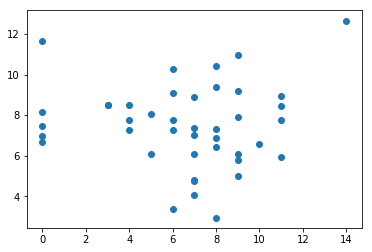

In [16]:
import matplotlib.pyplot as plt
plt.scatter(df['wins'], outcome)

In [17]:
scores.sort_values(ascending=False)

df['exp_wins'] = scores
df['error'] = df['wins'] - df['exp_wins']
np.absolute(df['error']).sort_values(ascending=False)

NameError: name 'scores' is not defined

## Begin making some features

In [18]:
def elo_stat(bout_history):
    ratings = defaultdict(lambda: 1000)
    ratings = play_all_bashos(ratings, bout_history)
    rikishi_data = pd.DataFrame(pd.Series(ratings), columns=['elo'])
    return rikishi_data

### Career wins/losses

In [19]:
def career_stats(rikishi_data, bout_history):
    career_wins = defaultdict(int)
    career_losses = defaultdict(int)
    career_injuries = defaultdict(int)
    for tournament in bout_history:
        for name, bouts in tournament[1].items():
            for bout in bouts:
                career_wins[name] += result_to_numeric(bout['result'])
                career_losses[name] += 1 if result_to_numeric(bout['result']) == 0 else 1
                career_injuries[name] += 1 if bout['result'] == 'fusenpai' else 0

    rikishi_data['career_wins'] = pd.Series(career_wins)
    rikishi_data['career_losses'] = pd.Series(career_losses)
    rikishi_data['career_bouts'] = rikishi_data['career_wins'] + rikishi_data['career_losses']
    rikishi_data['win_loss_ratio'] = rikishi_data['career_wins'] / rikishi_data['career_losses']
    rikishi_data['win_loss_ratio'].fillna(0, inplace=True)
    rikishi_data['career_injuries'] = pd.Series(career_injuries)
    return rikishi_data

### Last tournament performance

In [20]:
def last_tournament_stats(rikishi_data, bout_history):
    last_wins = defaultdict(int)
    last_losses = defaultdict(int)
    last_injured = defaultdict(int)
    for tournament in bout_history:
        for name, bouts in tournament[1].items():
            if name in last_wins:
                last_wins[name] = 0
                last_losses[name] = 0
                last_injured[name] = 0

            for bout in bouts:
                last_wins[name] += result_to_numeric(bout['result'])
                last_losses[name] += 1 if result_to_numeric(bout['result']) == 0 else 1
                last_injured[name] += 1 if bout['result'] == 'fusenpai' else 0


    rikishi_data['last_wins'] = pd.Series(last_wins)
    rikishi_data['last_losses'] = pd.Series(last_losses)
    rikishi_data['last_bouts'] = rikishi_data['last_wins'] + rikishi_data['last_losses']
    rikishi_data['last_win_loss_ratio'] = rikishi_data['last_wins'] / rikishi_data['last_losses']
    rikishi_data['last_win_loss_ratio'].fillna(0, inplace=True)
    rikishi_data['last_injured'] = pd.Series(last_injured)
    return rikishi_data

In [26]:
rikishi_data = elo_stat(all_bouts)
rikishi_data = career_stats(rikishi_data, all_bouts)
rikishi_data = last_tournament_stats(rikishi_data, all_bouts)
rikishi_data

,elo,career_wins,career_losses,career_bouts,win_loss_ratio,career_injuries,last_wins,last_losses,last_bouts,last_win_loss_ratio,last_injured
Chiyonofuji,1044.091862,65,82,147,0.792683,2,1,4,5,0.250000,1
Hokutoumi,996.267717,107,149,256,0.718121,2,0,0,0,0.000000,0
Onokuni,1043.317477,44,69,113,0.637681,1,4,9,13,0.444444,1
Konishiki,915.621253,368,677,1045,0.543575,5,5,14,19,0.357143,1
Asahifuji,976.216381,117,161,278,0.726708,2,0,4,4,0.000000,1
Hokutenyu,1008.713153,38,67,105,0.567164,1,2,7,9,0.285714,1
Mitoizumi,925.324552,382,818,1200,0.466993,3,5,15,20,0.333333,0
Kotogaume,913.358506,146,335,481,0.435821,1,5,15,20,0.333333,0
Terao,870.483055,421,959,1380,0.438999,1,2,15,17,0.133333,0
Kirishima,869.324404,284,532,816,0.533835,3,3,15,18,0.200000,0


In [205]:
from copy import deepcopy
total_data = []
for date, tournament in deepcopy(all_banzuke):
    for rikishi in tournament:
        rikishi['name_date'] = rikishi['name'] + date
    total_data.extend(tournament)
    
total_data = pd.DataFrame(total_data)
total_data.set_index('name_date')

def coarse_rank(rank):
    if rank == 'Y':
        return 0
    elif rank == 'O':
        return 1
    elif rank == 'S':
        return 2
    elif rank == 'K':
        return 3
    elif 'M' in rank:
        num = int(rank[1:])
        if num <= 5:
            return 4
        elif 5 < num <= 10:
            return 5
        else:
            return 6
    else:
        return 7
    
def detailed_rank(rank):
    if rank == 'Y':
        return 1
    elif rank == 'O':
        return 2
    elif rank == 'S':
        return 3
    elif rank == 'K':
        return 4
    elif 'M' in rank:
        num = int(rank[1:])
        return num+4
    else:
        return 0

total_data['coarse_rank'] = total_data['rank'].map(coarse_rank)
total_data['was_injured'] = total_data['absent'] > 0
total_data.head()

,absent,losses,name,name_date,rank,wins,coarse_rank,was_injured
0,0,1,Chiyonofuji,Chiyonofuji199001,Y,14,0,False
1,0,4,Hokutoumi,Hokutoumi199001,Y,11,0,False
2,0,7,Onokuni,Onokuni199001,HD,8,7,False
3,0,5,Konishiki,Konishiki199001,O,10,1,False
4,0,6,Asahifuji,Asahifuji199001,O,9,1,False


In [197]:
from scipy.optimize import minimize
from scipy.misc import factorial

plt.close('all')
fig = plt.figure()
ax = fig.subplots(1)

rikishi1 = total_data[total_data['name'] == 'Hakuho']
rikishi1 = rikishi1[~rikishi1['was_injured']]

rikishi2 = total_data[total_data['name'] == 'Ichinojo']
rikishi2 = rikishi2[~rikishi2['was_injured']]

def poisson(k, lamb):
    """poisson pdf, parameter lamb is the fit parameter"""
    return (lamb**k/factorial(k)) * np.exp(-lamb)


def negLogLikelihood(params, data):
    """ the negative log-Likelohood-Function"""
    lnl = - np.sum(np.log(poisson(data, params[0])))
    return lnl

def plot_rikishi_history(ax, wins):
    wins.plot.hist(bins=np.arange(0, 15), density=True, ax=ax)
    
    result = minimize(negLogLikelihood,  # function to minimize
                      x0=8,     # start value
                      args=(wins,),      # additional arguments for function
                      method='Powell',   # minimization method, see docs
                      )
    x_plot = np.linspace(0, 15, wins.shape[0])
    ax.plot(x_plot, poisson(x_plot, result.x), lw=2)

rikishi1_wins =  rikishi1['wins']
rikishi2_wins =  rikishi2['wins']
plot_rikishi_history(ax, rikishi1_wins)
plot_rikishi_history(ax, rikishi2_wins)

FigureCanvasNbAgg()

In [214]:
for date, tournament in all_bouts[:10]:
    for name, items in tournament.items:
        row = {'name': name, 'opponent': items['opponent']}
#     for bout in torunament:
    

defaultdict(<class 'list'>, {'Chiyonofuji': [{'day': 1, 'result': 'shiro', 'opponent': 'Ryogoku'}, {'day': 2, 'result': 'shiro', 'opponent': 'Kotoinazuma'}, {'day': 3, 'result': 'shiro', 'opponent': 'Itai'}, {'day': 4, 'result': 'shiro', 'opponent': 'Kirishima'}, {'day': 5, 'result': 'shiro', 'opponent': 'Sakahoko'}, {'day': 6, 'result': 'shiro', 'opponent': 'Tochitsukasa'}, {'day': 7, 'result': 'shiro', 'opponent': 'Terao'}, {'day': 8, 'result': 'shiro', 'opponent': 'Ozutsu'}, {'day': 9, 'result': 'shiro', 'opponent': 'Hokutenyu'}, {'day': 10, 'result': 'shiro', 'opponent': 'Kotogaume'}, {'day': 11, 'result': 'shiro', 'opponent': 'Kasugafuji'}, {'day': 12, 'result': 'shiro', 'opponent': 'Mitoizumi'}, {'day': 13, 'result': 'shiro', 'opponent': 'Asahifuji'}, {'day': 14, 'result': 'kuro', 'opponent': 'Konishiki'}, {'day': 15, 'result': 'shiro', 'opponent': 'Onokuni'}], 'Hokutoumi': [{'day': 1, 'result': 'kuro', 'opponent': 'Kirishima'}, {'day': 2, 'result': 'shiro', 'opponent': 'Ryogoku'

In [198]:
import pymc3 as pm

fml = 'wins ~ wins + career_wins + alcohol:antihist'

with pm.Model() as mdl_fish_alt:
    pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Poisson())

    with mdl_fish_alt:
        trc_fish_alt = pm.sample(2000, tune=2000)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [203]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.misc import factorial
from scipy.stats import kstest
    
fig = plt.figure()
axes = fig.subplots(3, 3)
axes = axes.flatten()

subset = total_data.loc[~total_data['was_injured']]
for ax, (idx, g) in zip(axes, subset.groupby('coarse_rank')):


    # the bins should be of integer width, because poisson is an integer distribution
    entries, bin_edges, patches = ax.hist(g['wins'], bins=15, density=True)
    unnormed, _ = np.histogram(g['wins'], bins=15)

    # calculate binmiddles
    bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
    # fit with curve_fit
    parameters, cov_matrix = curve_fit(poisson, bin_middles, unnormed, p0=8) 

    
    # plot poisson-deviation with fitted parameter
    x_plot = np.linspace(0, 15, 1000)
    ax.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)

FigureCanvasNbAgg()

In [55]:
asha = total_data.loc[total_data['name']=='Hakuho']

In [56]:
fig = plt.figure()
axes = fig.subplots(1)
subset_3 = asha
# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(subset_3['wins'], bins=15, density=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])
# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries, p0=8) 
x_plot = np.linspace(0, 15, 1000)
plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)

FigureCanvasNbAgg()

In [112]:
for date, torunament in all_banzuke[:10]:
    for data in tournament:
        print(data)

{'name': 'Harumafuji', 'wins': 0, 'losses': 3, 'absent': 12, 'rank': 'Y', 'name_date': 'Harumafuji201711'}
{'name': 'Hakuho', 'wins': 14, 'losses': 1, 'absent': 0, 'rank': 'Y', 'name_date': 'Hakuho201711'}
{'name': 'Kisenosato', 'wins': 4, 'losses': 6, 'absent': 5, 'rank': 'Y', 'name_date': 'Kisenosato201711'}
{'name': 'Kakuryu', 'wins': 0, 'losses': 0, 'absent': 15, 'rank': 'Y', 'name_date': 'Kakuryu201711'}
{'name': 'Goeido', 'wins': 9, 'losses': 6, 'absent': 0, 'rank': 'O', 'name_date': 'Goeido201711'}
{'name': 'Takayasu', 'wins': 8, 'losses': 5, 'absent': 2, 'rank': 'O', 'name_date': 'Takayasu201711'}
{'name': 'Mitakeumi', 'wins': 9, 'losses': 6, 'absent': 0, 'rank': 'S', 'name_date': 'Mitakeumi201711'}
{'name': 'Yoshikaze', 'wins': 6, 'losses': 9, 'absent': 0, 'rank': 'S', 'name_date': 'Yoshikaze201711'}
{'name': 'Terunofuji', 'wins': 0, 'losses': 5, 'absent': 10, 'rank': 'S', 'name_date': 'Terunofuji201711'}
{'name': 'Kotoshogiku', 'wins': 6, 'losses': 9, 'absent': 0, 'rank': 'K'

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([epl_1617[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1617[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

In [10]:
fig = plt.figure()
axes = fig.subplots(3, 3)
axes = axes.flatten()

subset = total_data.loc[total_data['was_injured']]
for ax, (idx, g) in zip(axes, subset.groupby('coarse_rank')):
    g.hist('absent', ax=ax)
    ax.set_title(idx)
plt.plot()

FigureCanvasNbAgg()

[]